In [1]:
!poetry add imitation


Using version ^1.0.0 for imitation

Updating dependencies
Resolving dependencies... (19.2s)://files.pythonhosted.org/packages/14/54/dc58f8b70e08b6706b158f0c70f86eb1594db6797cb89383f062ad6a304d/pygame-2.5.2-cp310-cp310-macosx_10_9_x86_64.whl  94% (15.8s)Resolving dependencies... Downloading https://files.pythonhosted.org/packages/14/54/dc58f8b70e08b6706b158f0c70f86eb1594db6797cb89383f062ad6a304d/pygame-2.5.2-cp310-cp310-macosx_10_9_x86_64.whl  99% (15.9s)Resolving dependencies... (19.3s)

Package operations: 63 installs, 0 updates, 0 removals

  • Installing frozenlist (1.4.0): Pending...
  • Installing multidict (6.0.4): Pending...
  • Installing pyasn1 (0.5.0): Pending...
  • Installing pyasn1 (0.5.0): Installing...
  • Installing pyasn1 (0.5.0): Installing...
  • Installing multidict (6.0.4): Installing...
  • Installing pyasn1 (0.5.0): Installing...
  • Installing multidict (6.0.4): Installing...
  • Installing pyasn1 (0.5.0): Installing...
  • Installing frozenlist (1.4.0): Install

In [1]:
from functools import partial

from seals import base_envs
from seals.diagnostics.cliff_world import CliffWorldEnv
from stable_baselines3.common.vec_env import DummyVecEnv

import numpy as np

from imitation.algorithms.mce_irl import (
    MCEIRL,
    mce_occupancy_measures,
    mce_partition_fh,
    TabularPolicy,
)
from imitation.data import rollout
from imitation.rewards import reward_nets

env_creator = partial(CliffWorldEnv, height=4, horizon=40, width=7, use_xy_obs=True)
env_single = env_creator()

state_env_creator = lambda: base_envs.ExposePOMDPStateWrapper(env_creator())

# This is just a vectorized environment because `generate_trajectories` expects one
state_venv = DummyVecEnv([state_env_creator] * 4)

In [2]:
env_single.state_space

Discrete(28)

In [3]:
env_single.action_space

Discrete(4)

In [5]:
_, _, pi = mce_partition_fh(env_single)

In [10]:
pi.shape


(40, 28, 4)

In [5]:
_, _, pi = mce_partition_fh(env_single)

_, om = mce_occupancy_measures(env_single, pi=pi)

rng = np.random.default_rng()
expert = TabularPolicy(
    state_space=env_single.state_space,
    action_space=env_single.action_space,
    pi=pi,
    rng=rng,
)

expert_trajs = rollout.generate_trajectories(
    policy=expert,
    venv=state_venv,
    sample_until=rollout.make_min_timesteps(5000),
    rng=rng,
)

print("Expert stats: ", rollout.rollout_stats(expert_trajs))

/Users/jackcontro/Library/Caches/pypoetry/virtualenvs/navigation-app-backend-SON1y8JS-py3.10/lib/python3.10/site-packages/imitation/data/types.py:279: UserWarning: tried to wrap <class 'numpy.int64'> as an observation
  warnings.warn(f"tried to wrap {type(obs)} as an observation")


Expert stats:  {'n_traj': 128, 'return_min': 305.0, 'return_mean': 325.9375, 'return_std': 7.90939907641535, 'return_max': 334.0, 'len_min': 40, 'len_mean': 40.0, 'len_std': 0.0, 'len_max': 40}


In [6]:
import matplotlib.pyplot as plt
import torch as th


def train_mce_irl(demos, hidden_sizes, lr=0.01, **kwargs):
    reward_net = reward_nets.BasicRewardNet(
        env_single.observation_space,
        env_single.action_space,
        hid_sizes=hidden_sizes,
        use_action=False,
        use_done=False,
        use_next_state=False,
    )

    mce_irl = MCEIRL(
        demos,
        env_single,
        reward_net,
        log_interval=250,
        optimizer_kwargs=dict(lr=lr),
        rng=rng,
    )
    occ_measure = mce_irl.train(**kwargs)

    imitation_trajs = rollout.generate_trajectories(
        policy=mce_irl.policy,
        venv=state_venv,
        sample_until=rollout.make_min_timesteps(5000),
        rng=rng,
    )
    print("Imitation stats: ", rollout.rollout_stats(imitation_trajs))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(occ_measure)
    plt.title("Occupancy for learned reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.subplot(1, 2, 2)
    _, true_occ_measure = mce_occupancy_measures(env_single)
    env_single.draw_value_vec(true_occ_measure)
    plt.title("Occupancy for true reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(
        reward_net(th.as_tensor(env_single.observation_matrix), None, None, None)
        .detach()
        .numpy()
    )
    plt.title("Learned reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.subplot(1, 2, 2)
    env_single.draw_value_vec(env_single.reward_matrix)
    plt.title("True reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.show()

    return mce_irl

--------------------------
| grad_norm   | 106      |
| iteration   | 0        |
| linf_delta  | 33.3     |
| weight_norm | 11.2     |
--------------------------
--------------------------
| grad_norm   | 0.598    |
| iteration   | 250      |
| linf_delta  | 0.2      |
| weight_norm | 17.3     |
--------------------------
--------------------------
| grad_norm   | 0.506    |
| iteration   | 500      |
| linf_delta  | 0.2      |
| weight_norm | 19.5     |
--------------------------
--------------------------
| grad_norm   | 0.794    |
| iteration   | 750      |
| linf_delta  | 0.2      |
| weight_norm | 24.6     |
--------------------------
Imitation stats:  {'n_traj': 128, 'return_min': 289.0, 'return_mean': 325.3046875, 'return_std': 8.982238196983186, 'return_max': 334.0, 'len_min': 40, 'len_mean': 40.0, 'len_std': 0.0, 'len_max': 40}


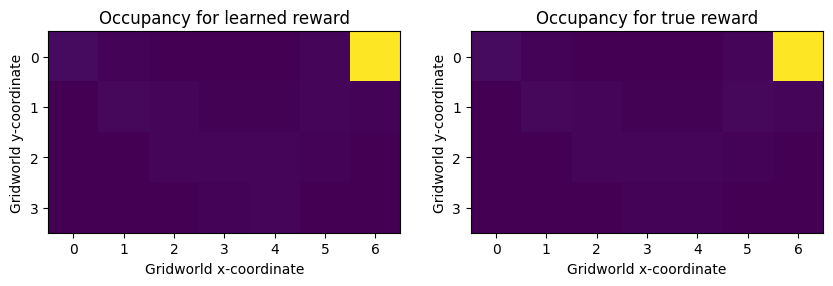

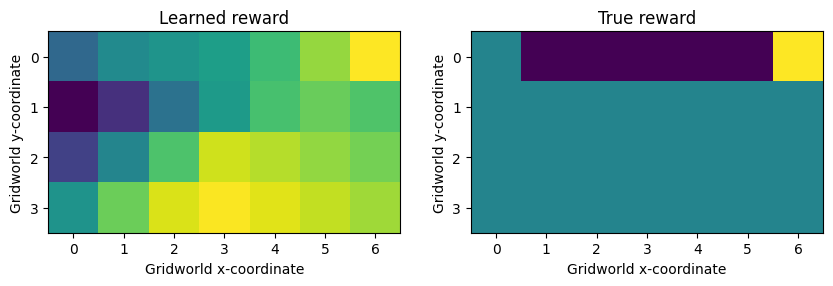

In [10]:
mce_irl_from_trajs = train_mce_irl(expert_trajs[0:10], hidden_sizes=[256])

In [8]:
pi

array([[[1.66941249e-05, 1.11138376e-04, 3.51004687e-04, 9.99521163e-01],
        [3.09465993e-10, 2.07696147e-04, 6.50672106e-09, 9.99792297e-01],
        [2.04361086e-14, 1.32687739e-04, 1.83791807e-10, 9.99867312e-01],
        ...,
        [9.05904862e-10, 9.99983271e-01, 2.12579248e-09, 1.67254852e-05],
        [1.10436179e-04, 9.99839546e-01, 1.66628233e-05, 3.33548264e-05],
        [4.99554230e-01, 5.00420720e-01, 8.35542665e-06, 1.66941249e-05]],

       [[1.66941249e-05, 1.11138376e-04, 3.51004687e-04, 9.99521163e-01],
        [3.09465993e-10, 2.07696147e-04, 6.50672106e-09, 9.99792297e-01],
        [2.04361086e-14, 1.32687739e-04, 1.83791807e-10, 9.99867312e-01],
        ...,
        [9.05904862e-10, 9.99983271e-01, 2.12579248e-09, 1.67254852e-05],
        [1.10436179e-04, 9.99839546e-01, 1.66628233e-05, 3.33548264e-05],
        [4.99554230e-01, 5.00420720e-01, 8.35542665e-06, 1.66941249e-05]],

       [[1.66941249e-05, 1.11138376e-04, 3.51004687e-04, 9.99521163e-01],
        

In [11]:
env_single.reward_matrix

array([ -1., -10., -10., -10., -10., -10.,  10.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.])